<a href="https://colab.research.google.com/github/ekagra-ranjan/Auto-SCMA/blob/main/SCMA_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import itertools
import math

torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("\nDevice:", device)

seed = 6789 # also 0, 6789
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device is not "cpu":
    torch.cuda.manual_seed_all(seed)
    torch.cuda.set_rng_state(torch.cuda.get_rng_state())
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

eps = 1e-8


Device: cuda:0


In [2]:
# Number of symbols
M = 4
# Number of users
J = 6
# Number of orthogonal resources
K = 4

'''
Throughout the code we will refer Paper 10 as
S. Zhang, K. Xiao, B. Xiao, Z. Chen, B. Xia, D. Chen, and S. Ma,
“A capacity-based codebook design method for sparse code multiple
access systems,” in 2016 8th International Conference on Wireless
Communications & Signal Processing (WCSP). IEEE, 2016.

and Paper 11 as
M. Vaezi, Z. Ding, and H. V. Poor, Multiple access techniques for 5G
wireless networks and beyond. Springer, 2019.

This naming convention is taken from our paper https://ieeexplore.ieee.org/document/9530173
'''

# Paper 10: sparse mapping matrix V: K x J
V = torch.tensor([[1, 0, 1, 0, 1, 0],
                  [0, 1, 1, 0, 0, 1],
                  [1, 0, 0, 1, 0, 1],
                  [0, 1, 0, 1, 1, 0]
            ], dtype = torch.int32, device=device)


# Paper 11: sparse mapping matrix V: K x J
# V = torch.tensor([[0, 1, 1, 0, 1, 0],
#                   [1, 0, 1, 0, 0, 1],
#                   [0, 1, 0, 1, 0, 1],
#                   [1, 0, 0, 1, 1, 0]
#                 ], dtype = torch.int32, device=device)

In [3]:
# paper 10 codebook 
user_1_code_real = np.array([[ -1.3498, -0.4218, 0.4218, 1.3498],
             [0, 0, 0, 0],
             [-0.1980, 0.6337, -0.6337, 0.1980],
             [0, 0, 0, 0]])
user_1_code_imag = np.array([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [-0.3724, 1.1918, -1.1918, 0.3724],
             [ 0, 0, 0, 0]])

user_2_code_real = np.array([[0, 0, 0, 0],
             [-0.1980, 0.6337, -0.6337, 0.1980],
             [0, 0, 0, 0],
            [-1.3498, -0.4218, 0.4218, 1.3498]])
user_2_code_imag = np.array([[0, 0, 0, 0],
             [-0.3724, 1.1918, -1.1918, 0.3724],
             [0, 0, 0, 0],
             [0, 0, 0, 0]])

user_3_code_real = np.array([[-0.6337, -0.1980, 0.1980, 0.6337],
             [0.2109, -0.6749, 0.6749, -0.2109],
             [0, 0, 0, 0],
             [0, 0, 0, 0]])
user_3_code_imag = np.array([[-1.1918, -0.3724, 0.3724, 1.1918],
             [-0.3653, 1.1690, -1.1690, 0.3653],
             [0, 0, 0, 0],
             [0, 0, 0, 0]])

user_4_code_real = np.array([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [-1.3498, -0.4218, 0.4218, 1.3498],
             [0.2109, -0.6749, 0.6749, -0.2109]])
user_4_code_imag = np.array([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [-0.3653, 1.1690, -1.1690, 0.3653]])

user_5_code_real = np.array([[0.2109, -0.6749, 0.6749, -0.2109],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [-0.6337, -0.1980, 0.1980, 0.6337]])
user_5_code_imag = np.array([[-0.3653, 1.1690, -1.1690, 0.3653],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [-1.1918, -0.3724, 0.3724, 1.1918]])

user_6_code_real = np.array([[0, 0, 0, 0],
             [ -1.3498, -0.4218, 0.4218, 1.3498],
             [0.2109, -0.6749, 0.6749, -0.2109],
             [ 0, 0, 0, 0]])
user_6_code_imag = np.array([[0, 0, 0, 0],
             [0, 0, 0, 0],
             [-0.3653, 1.1690, -1.1690, 0.3653],
             [ 0, 0, 0, 0]])

# Paper 11 scma codebook
# user_1_code_real = np.array([[ 0                 , 0                 , 0                 , 0],
#              [-0.1815  ,-0.6351  , 0.6351  , 0.1815],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0.7851            ,-0.2243            , 0.2243            ,-0.7851 ]])
# user_1_code_imag = np.array([[ 0                 , 0                 , 0                 , 0],
#              [-0.1318  ,-0.4615  ,0.4615  ,0.1318],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0            ,0            , 0            ,0 ]])

# user_2_code_real = np.array([[ 0.7851            ,-0.2243            , 0.2243            ,-0.7851],
#              [ 0                 , 0                 , 0                 , 0],
#              [-0.1815  ,-0.6351  , 0.6351  , 0.1815],
#              [ 0                 , 0                 , 0                 , 0 ]])
# user_2_code_imag = np.array([[ 0            ,0            , 0            ,0],
#              [ 0                 , 0                 , 0                 , 0],
#              [-0.1318  ,-0.4615  ,0.4615  ,0.1318],
#              [ 0                 , 0                 , 0                 , 0 ]])

# user_3_code_real = np.array([[-0.6351  , 0.1815  ,-0.1815  , 0.6351],
#              [ 0.1392  , 0.4873  ,-0.4873  ,-0.1392],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0                 , 0                 , 0                 , 0 ]])
# user_3_code_imag = np.array([[0.4615  ,-0.1318  ,0.1318  ,-0.4615],
#              [-0.1759  ,-0.6156  ,0.6156  ,0.1759],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0                 , 0                 , 0                 , 0 ]])

# user_4_code_real = np.array( [[ 0                 , 0                 , 0                 , 0],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0.7851            ,-0.2243            , 0.2243            ,-0.7851],
#              [-0.0055  ,-0.0193  , 0.0193  , 0.0055 ]])
# user_4_code_imag = np.array([[ 0                 , 0                 , 0                 , 0],
#              [ 0                 , 0                 , 0                 , 0],
#              [0            ,0            , 0            ,0],
#              [-0.2242  ,-0.7848  ,0.7848  ,0.2242 ]])

# user_5_code_real = np.array([[-0.0055  ,-0.0193  , 0.0193  , 0.0055],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0                 , 0                 , 0                 , 0],
#              [-0.6351  , 0.1815  ,-0.1815  , 0.6351 ]])
# user_5_code_imag = np.array([[-0.2242  ,-0.7848  ,0.7848  ,0.2242],
#              [ 0                 , 0                 , 0                 , 0],
#              [ 0                 , 0                 , 0                 , 0],
#              [0.4615  ,-0.1318  ,0.1318  ,-0.4615 ]])

# user_6_code_real = np.array([[ 0                 , 0                 , 0                 , 0],
#              [ 0.7851            ,-0.2243            , 0.2243            ,-0.7851],
#              [ 0.1392  , 0.4873  ,-0.4873  ,-0.1392],
#              [ 0                 , 0                 , 0                 , 0 ]])
# user_6_code_imag = np.array([[ 0                 , 0                 , 0                 , 0],
#              [ 0            ,0            , 0            ,0],
#              [-0.1759  ,-0.6156  ,0.6156  ,0.1759],
#              [ 0                 , 0                 , 0                 , 0 ]])

codebook = np.stack([np.stack([user_1_code_real, user_1_code_imag], axis=2), np.stack([user_2_code_real, user_2_code_imag], axis=2),
                    np.stack([user_3_code_real, user_3_code_imag], axis=2), np.stack([user_4_code_real, user_4_code_imag], axis=2),
                    np.stack([user_5_code_real, user_5_code_imag], axis=2), np.stack([user_6_code_real, user_6_code_imag], axis=2)])
codebook = np.transpose(codebook, (0, 2, 1, 3))
# codebook shape : [J, M, K, 2]

In [4]:
codebook = codebook[:J, :M, :K]
codebook = torch.Tensor(codebook).to(device)
# codebook shape : [J, M, K, 2]

In [5]:
def encode(symbols, codebook, h=None):
    '''
    Inputs: symbols: [BS, J], h: [BS, J, 2*K], codebook: [J, M, K, 2],
    Returns [BS, 2*K]
    '''

    batch_size = symbols.shape[0]
    encoded = torch.zeros((batch_size, 2*K)).to(device)
    encoded_without_h = torch.zeros((batch_size, 2*K)).to(device)
    
    for user in range(J):
        # pdb()
        codeword = codebook[user][symbols[:, user]-1] # [BS, K, 2]
        codeword = codeword * V[:, user].reshape(1, -1, 1) # makes sure that codeword for resources not connected dont exist
        codeword = codeword.view(-1, 2*K) # [BS, 2*K]
        encoded_without_h = encoded_without_h + codeword
        codeword_faded = torch.zeros_like(codeword)
        
        if h is not None:
            '''CORRECT THE MULT WITH H'''
            real_idx = 2 * torch.arange(K).long()
            img_idx = 2 * torch.arange(K).long() + 1
            codeword_faded[:, real_idx] = codeword_faded[:, real_idx] + \
                                          (h[:, user, real_idx] * codeword[:, real_idx]) - \
                                          (h[:, user, img_idx] * codeword[:, img_idx])
            codeword_faded[:, img_idx]  = codeword_faded[:, img_idx] + \
                                          (h[:, user, real_idx] * codeword[:, img_idx]) + \
                                          (h[:, user, img_idx] * codeword[:, real_idx])
        else:
            codeword_faded = codeword_faded + codeword

        encoded = encoded + codeword_faded
    
    return encoded, encoded_without_h

In [6]:
def calc_distance(a, b):
    '''
    Args: a: [BS, 2]    b: [BS, M**df, 2]
    Returns: distance: [BS, M**df]
    '''
    a = a.view(-1, 1, 2)
    return ((a-b)**2).sum(-1).squeeze(-1)




def get_codebook_centre_resource(codebook, h, resource_id):
    '''
    Inputs:
        codebook: [J, M, K, 2]
        h dim: [batch_size, J, 2*K]
        V: K x J

    Outputs:
        centres_all [BS, M**df, 2]: contains the real and img part of
                                    codewords for all permutation
                                    (i.e., M**df) of user symbols
                                    connected to kth resource,
                                    i.e., \sum_{j} h^{T}x_{j}
        x_centres_all [BS, M**df, 2*df]: contains the real and img part of
                                         each df users in codewords for all
                                         permutation (i.e., M**df) of user
                                         symbols connected to kth resource, x_{j}
    '''
    centres_all = torch.zeros((h.shape[0], M**df, 2), device=device)        # [BS, M**df, 2]
    x_centres_all = torch.zeros((M**df, 2*df), device=device)               # [M**sd, 2*df]
            

    #---Create centres_all
    resource_user_idx = V[resource_id].nonzero().reshape(-1)
    alphabets = np.arange(1, M+1)
    symbols_resource = [torch.tensor(p) for p in itertools.product(alphabets, repeat=df)] 
    symbols_resource = torch.stack(symbols_resource).to(device)             # [M**df, df]

    symbols_resource.unsqueeze_(0)                                          # [1, M**df, df]
    symbols_resource = symbols_resource.repeat(h.shape[0], 1, 1)            # [BS, M**df, df]
    
    symbols_resource_all = torch.zeros((M**df, J),\
                                        dtype = torch.int64, device=device) # [M**df, J]
    symbols_resource_all[:, resource_user_idx] = symbols_resource[0]        # [M**df, J]
    
    h_repeat_perm = h.unsqueeze(1).repeat(1, M**df, 1, 1)                   # [BS, M**df, J, 2*K]
    h_repeat_perm = h_repeat_perm.view(-1, J, 2*K)                          # [BS * M**df, J, 2*K]
    
     
    symbols_resource = symbols_resource.view(-1, df)                        # [BS * M**df, df]
    codeword_faded_k = torch.zeros((symbols_resource.shape[0], 2), device=device)
    
    for user_idx, user in enumerate(resource_user_idx):
        codeword = codebook[user][symbols_resource[:, user_idx]-1]          # [BS, K, 2]
        codeword_k = codeword[:, resource_id, :]                            # [BS, 2]
        codeword_k = codeword_k * V[resource_id, user] # makes sure that codeword for resources not connected dont exist
        
        '''CORRECT THE MULT WITH H'''
        real_idx = 2 * resource_id
        img_idx = 2 * resource_id + 1
        codeword_faded_k[:, 0] = codeword_faded_k[:, 0] + \
                                        (h_repeat_perm[:, user, real_idx] * codeword_k[:, 0]) - \
                                        (h_repeat_perm[:, user, img_idx] * codeword_k[:, 1])
        codeword_faded_k[:, 1]  = codeword_faded_k[:, 1] + \
                                        (h_repeat_perm[:, user, real_idx] * codeword_k[:, 1]) + \
                                        (h_repeat_perm[:, user, img_idx] * codeword_k[:, 0])
    
    centres_all[:, :, :] = codeword_faded_k.view(h.shape[0], M**df, 2) 
    

    # ---Create x_centres_all
    symbols_resource_all = symbols_resource_all.unsqueeze(1).repeat(1, df, 1) # [M**df, df, J]
    symbols_resource_all = symbols_resource_all.view(-1, J)                 # [M**df * df, J]
    h_x = torch.zeros((df, J, 2*K), device=device)                          # [df, J, 2*K]
    real_idx = 2 * torch.arange(K).long()
    temp = torch.zeros((2*K), device=device)
    temp[real_idx] = 1.0
    
    for idx, val in enumerate(V[resource_id].nonzero().reshape(-1)):
        h_x[idx, val, :] = temp
    
    h_x = h_x.view(1, df, J, 2*K)
    h_x = h_x.repeat(M**df, 1, 1, 1)                                        # [M**df, df, J, 2*K]
    h_x = h_x.view(-1, J, 2*K)
    x_centres, _ = encode(symbols_resource_all, codebook, h=h_x)            # [M**df * df, 2*K]
    x_centres = x_centres.view(M**df, df,2*K)\
                [:, :, 2 * resource_id: 2 * resource_id + 2]                # [M**df, df, 2]
    x_centres = x_centres.reshape(M**df, 2 * df)
    x_centres_all[:, :] = x_centres
    
    return centres_all, x_centres_all

In [7]:
df = (V[0]==1).sum() # num of users connected to kth resource
dv = (V.t()[0]==1).sum() # num of resources connected to jth user


class MPA():

    def resource_to_user(self, x, u2r, codebook, h, sigma_square, beta):
        '''
        Inputs:  x: [BS, 2*K] , i.e., received signal, u2r: [BS, J, K, M], h: [BS, J, 2*K]
        Output: [BS, K, J, M]
        '''

        message_all = torch.zeros((h.shape[0], K, J, M), device=device)
        
        for i in range(0, K):
            '''
            centres_all: [batch_size, M**df, 2]
            x_centres_all: [BS, M**df, 2*df]
            '''
            centres_all, x_centres_all = get_codebook_centre_resource(codebook, h, i)
            x_centres_all = x_centres_all.view(1, M**df, df, 2) # [1, M**df, df, 2]

            distance = calc_distance(x[:, 2*i:2*i+2], centres_all) # distance([BS, 2], [BS, M**df, 2]) -> [BS, M**df]
            distance = - (1.0/(2.0 * sigma_square)) * distance
            assert distance.dtype == torch.float32, "distance is not float32"
            M_k = torch.zeros((h.shape[0], J, M), device=device) # conditional prob of x_{j} given r_{k}

            u2r_ = u2r.permute(0, 2, 1, 3) # [BS, K, J, M]


            '''Check from here'''
            alphabets = np.arange(0, M)
            symbols_resource = [torch.tensor(p) for p in itertools.product(alphabets, repeat=df)] 
            symbols_resource = torch.stack(symbols_resource) # [M**df, df]
            
            u2r_resource = u2r_[:, i, V[i]==1] # [BS, df, M]
            prior_big = torch.zeros((h.shape[0], M**df, df), device=device) # [BS, M**df, df]

            for df_idx in range(df):
                
                # if df_idx == idx: # do not add the current user message
                #     continue
                
                u2r_resource_df = u2r_resource[:, df_idx, :] # [BS, M]
                u2r_resource_df = u2r_resource_df.reshape(1, -1) # [1, BS * M]
                symbols_resource_df = symbols_resource[:, df_idx].unsqueeze(0).repeat(h.shape[0], 1) # [BS, M**df]
                incrementor = torch.arange(0, M * h.shape[0], M).view(-1, 1) # [BS, 1]
                symbols_resource_df_mask = symbols_resource_df + incrementor # [BS, M**df]
                symbols_resource_df_mask = symbols_resource_df_mask.view(1, -1) # [1, BS * M**df]
                prior_big_df = u2r_resource_df[0, symbols_resource_df_mask] # [1, BS * M**df]
                prior_big_df = prior_big_df.view(-1, M**df) # [BS, M**df]
                prior_big[:, :, df_idx] = prior_big_df # [BS, M**df, df]

            prior_big_sum = prior_big.sum(-1) # [BS, M**df]
            
            user_idx = (V[i]).nonzero().reshape(-1)
            
            for idx, j in enumerate(user_idx):    
                '''Careful: codebook is [J, M, K, 2] which is numpy'''
                df_unique = codebook[j, :, i, :] # [M, 2]
                x_centres_all_temp = x_centres_all[:, :, idx] # [1, M**df, 2]
                assert df_unique.dtype == x_centres_all_temp.dtype, "comparison vars dont have same dtype for mask_temp"

                mask_temp = (df_unique.view(1, M, 1, 2) == x_centres_all_temp.view(1, 1, M**df, 2)) # [1, M, M**df, 2]
                mask = (mask_temp.sum(-1)==2) # [1, M, M**df]: for matching, both real and img parts will match hence 2.
                mask = mask.repeat(h.shape[0], 1, 1) # [BS, M, M**df]

                prior_big_m = prior_big_sum - prior_big[:, :, idx] # [BS, M**df]
                message = distance + prior_big_m # [BS, M**df]
                lowest_message = message.min()

                message = message.unsqueeze(1).repeat(1, M, 1) # [BS, M, M**df]
                message = torch.where(mask, message, lowest_message) # [BS, M, M**df]
                
                #---log-sum-MPA
                message_max = message.max(-1)[0] # [BS, M]: 0 is used to use take the max and not the indices
                message = message - message_max.view(-1, M, 1)
                message = torch.exp(message) # [BS, M, M**df]
                message = torch.where(mask, message, torch.tensor([0.0], device=device))
                message = message.sum(-1) # [BS, M]
                
                message = torch.log(message) # [BS, M]
                message = message + message_max # [BS, M]
                
                #---Max log MPA
                # message = message.max(-1)[0] # [BS]: 0 is used to use take the max and not the indices
                
                message_all[:, i, j] = message + beta
                 
        return message_all




    def user_to_resource(self, r2u, gamma):
        '''
        Input: r2u: [BS, K, J, M]
        Returns [BS, J, K, M]
        '''
        assert (r2u == float("-inf")).sum() == 0, "r2u has -inf values!" # if -inf, then need to implement the counting of -inf freq

        message_all = torch.zeros((r2u.shape[0], J, K, M), device=device)
        r2u_ = r2u.permute(0, 2, 1, 3) # [BS, J, K, M]
        # to filter out messages to those resources which are not onnected to the user
        mask = torch.where(r2u_!=0, torch.tensor([1.0], device=device), torch.tensor([0.0], device=device))

        ''' Need to change'''
        message_all = -r2u_ # [BS, J, K, M]
        for i in range(J):
            message_all[:, i, :, :] = message_all[:, i, :, :] + r2u_[:, i].sum(-2).view(-1, 1, M) + gamma # [BS, 1, M]
        message_all = mask * message_all
        
        #---normalisation

        Z = torch.exp(message_all)
        Z = torch.where(message_all!=0, Z, torch.tensor([torch.exp(-gamma) / M], device=device)) # [BS, J, K, M]
        Z = torch.log(Z.sum(-1))

        message_all = message_all - Z.view(-1, J, K, 1) # [BS, J, K, M]

        return message_all




    def calc_output(self, r2u):
        '''
        Input: r2u: [BS, K, J, M]
        Output: [BS, J, M]
        '''
        r2u_ = r2u.permute(0, 2, 3, 1) # [BS, J, M, K]
        return r2u_.sum(-1) + gamma



    def forward(self, x, codebook, h, sigma_square, beta, gamma):
        ''' 
        Inputs:
        x: [BS, 2*K] , i.e., received signal
        h: [BS, J, 2*K]

        Variables used:
        u2r [BS, J, K, M]: user to resource message
        r2u [BS, K, J, M]: resource to user message
        '''
        
        u2r = torch.zeros((x.shape[0], J, K, M), device=device) # Initialise u2r with 0
        u2r = u2r + gamma
        
        r2u = self.resource_to_user(x, u2r, codebook, h, sigma_square, beta) # [BS, K, J, M]
        u2r = self.user_to_resource(r2u, gamma) # [BS, J, K, M]
        
        for i in range(n_iter - 1):
            r2u = self.resource_to_user(x, u2r, codebook, h, sigma_square, beta) # [BS, K, J, M]
            u2r = self.user_to_resource(r2u, gamma) # [BS, J, K, M]
        
        y = self.calc_output(r2u)
        return y

In [8]:
def add_noise(codewords, J, snr):
    '''
    codewords: [batch_size, 2*K]
    snr: scalar
    '''
    batch_size = codewords.shape[0]
    Es = torch.mean(codewords**2) # per real value or img value
    Es_db = 10*torch.log10(Es)
    noise_db = Es_db - torch.as_tensor(snr).to(device)
    noise_power = 10**(noise_db/10)
    noise = torch.randn(batch_size, 2*K).to(device) * torch.sqrt(noise_power).to(device)
    output = codewords + noise

    return noise, noise_power

In [9]:
def compute_ber(symbols, decoded_symbols, M):
    '''
    Inputs: symbols, decoded_symbols: [BS*J]
    '''
    symbols_0 = symbols - 1
    decoded_symbols_0 = decoded_symbols - 1
    true = np.unpackbits(symbols_0.reshape(-1, 1).astype('uint8'), axis=1)[:, -int(np.log2(M)):] # [BS*J, log2(M)]
    predicted = np.unpackbits(decoded_symbols_0.reshape(-1, 1).astype('uint8'), axis=1)[:, -int(np.log2(M)):] # [BS*J, log2(M)]

    Nerr_check = (true!=predicted) # [BS*J, log2(M)]
    ber_batch = (true!=predicted).mean() # [1]
    
    Nerr_per_user = np.sum(Nerr_check, axis=-1) # [BS*J]
    Nerr_per_user = np.sum(Nerr_per_user.reshape(-1, J), axis=0) # [J]
    

    return ber_batch, Nerr_per_user

In [10]:
batch_size = 10000
n_iter = 3
df = (V[0]==1).sum() # num of users connected to a resource (needs to be same for all resources)
dv = (V[:, 0]==1).sum() # num of resources connected to a user (needs to be same for all users)

#---Create MPA
mpa = MPA()

In [11]:
symbols = np.random.randint(1, M+1, (batch_size, J))
enc = OneHotEncoder(categories=np.stack(J*[range(1,M+1)]))
_ = enc.fit(symbols)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':


In [12]:
#---Testing
is_fading = False # controls fading
is_noise  = True # controls AWGN 
EbN = np.arange(0, 15+1)

accuracy_all = np.zeros_like(EbN ,dtype=np.float64)
ber_all = np.zeros_like(EbN ,dtype=np.float64)
test_samples = 10000
steps = 10 # total_samples = step * test_samples

maxNumErrs = 100 # min number of bits error to be seen before ending the run
maxNumBits = 1e7 # max number of bits per user to be processed

with torch.no_grad():
    for i, ebn in enumerate(EbN):

        Nerr_per_user = np.zeros([J])
        Nbits = 0 # number of bits processed till now
        accuracy_ebn = []
        wrong_symbols_ebn = []
        ber_ebn = []
        wrong_bits_ebn = []

        # steps = test_samples // 10000
        step = 1

        # NOTE: Use the 1st while condition when using AWGN for faster results
        while(step <= steps):
        # while( (Nerr_per_user.min() < maxNumErrs) and (Nbits < maxNumBits) ):
        
            step = step + 1

            snr = ebn + 10*np.log10(np.log2(M)*J/K)

            # codebook = get_codebook_from_condensed_codebook()

            #---Generate symbols and channel parameters
            symbols = np.random.randint(1, M+1, (test_samples, J))
            symbols_one_hot = torch.Tensor(enc.transform(symbols).toarray().reshape((test_samples, J, M))).to(device) # [test_samples, J, M]

            #---Fading
            if is_fading is True:
                h = (torch.randn(test_samples, J, 2*K)/torch.sqrt(torch.tensor(2.0))).to(device)
            else:
                h = torch.zeros(test_samples, J, 2*K).to(device)
                real_idx = 2 * torch.arange(K).long()
                h[:, :, real_idx] = 1.0
                
            #---Encode
            codewords_faded, codewords_faded_without_h = encode(symbols, codebook, h = h)    
            received_signal = codewords_faded
            
            #---Noise
            '''noise is being calc using codewords_faded_without_h '''
            noise, sigma_square = add_noise(codewords_faded_without_h, J, snr)
            
            if is_noise is True:
                received_signal = received_signal + noise
            

            #---Decode
            beta = torch.log((1/(2* math.pi * sigma_square)**0.5))
            gamma = torch.log(torch.tensor((1.0/M), device=device, dtype=torch.float32)) # log(p_x{j})
            decoded_symbols_one_hot = mpa.forward(received_signal, codebook, h, sigma_square, beta, gamma)
            
            
            #---Compute metrics
            decoded_symbols = torch.argmax(decoded_symbols_one_hot, dim=-1) + 1
            accuracy_batch = np.mean(symbols == decoded_symbols.cpu().data.numpy())
            wrong_symbols_batch = (symbols != decoded_symbols.cpu().data.numpy()).sum()
            ber_batch, Nerr_per_user = compute_ber(symbols.reshape(test_samples*J), decoded_symbols.cpu().data.numpy().reshape(test_samples*J), M)
            wrong_bits_batch = Nerr_per_user.sum()

            accuracy_ebn.append(accuracy_batch)
            wrong_symbols_ebn.append(wrong_symbols_batch)
            ber_ebn.append(ber_batch)
            wrong_bits_ebn.append(wrong_bits_batch)

            Nerr_per_user += Nerr_per_user
            Nbits += test_samples * np.log2(M)

        accuracy = np.array(accuracy_ebn).mean()
        wrong_symbols = np.array(wrong_symbols_ebn).sum()
        ber = np.array(ber_ebn).mean()
        wrong_bits = np.array(wrong_bits_ebn).sum()
        accuracy_all[i] = accuracy
        ber_all[i] = ber

        print("EbN:", ebn, ' Acc: {:.8f}'.format(accuracy),
            ' SER: {:.8f}'.format(1-accuracy),'BER: {:.8f}'.format(ber),
            ' Wrong Symbols: ', wrong_symbols, '/', test_samples*steps*J,
            ' Wrong Bits: ', wrong_bits, '/', test_samples*steps*J*np.log2(M))


EbN: 0  Acc: 0.72987500  SER: 0.27012500 BER: 0.14854083  Wrong Symbols:  162075 / 600000  Wrong Bits:  178249 / 1200000.0
EbN: 1  Acc: 0.76745500  SER: 0.23254500 BER: 0.12864500  Wrong Symbols:  139527 / 600000  Wrong Bits:  154374 / 1200000.0
EbN: 2  Acc: 0.80808333  SER: 0.19191667 BER: 0.10695083  Wrong Symbols:  115150 / 600000  Wrong Bits:  128341 / 1200000.0
EbN: 3  Acc: 0.85187333  SER: 0.14812667 BER: 0.08359667  Wrong Symbols:  88876 / 600000  Wrong Bits:  100316 / 1200000.0
EbN: 4  Acc: 0.89292667  SER: 0.10707333 BER: 0.06091000  Wrong Symbols:  64244 / 600000  Wrong Bits:  73092 / 1200000.0
EbN: 5  Acc: 0.92835500  SER: 0.07164500 BER: 0.04091000  Wrong Symbols:  42987 / 600000  Wrong Bits:  49092 / 1200000.0
EbN: 6  Acc: 0.95593500  SER: 0.04406500 BER: 0.02518667  Wrong Symbols:  26439 / 600000  Wrong Bits:  30224 / 1200000.0
EbN: 7  Acc: 0.97499167  SER: 0.02500833 BER: 0.01421333  Wrong Symbols:  15005 / 600000  Wrong Bits:  17056 / 1200000.0
EbN: 8  Acc: 0.98776833  

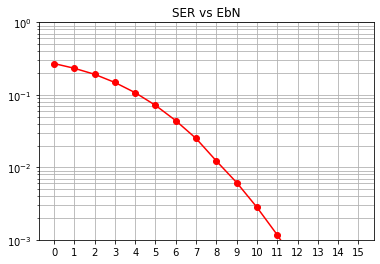

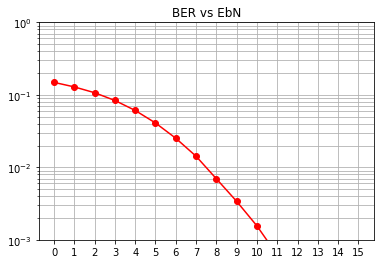

In [13]:
#---Plot Metrics across different channels
ymin = 1e-3
ymax = 1e-0
xmin = EbN[0]
xmax = EbN[-1]


f1 = plt.figure()
f2 = plt.figure()

ax1 = f1.add_subplot(111)
ax1.set_title('SER vs EbN')
ax1.set_yscale('log')
ax1.set_ylim([ymin,ymax])
# ax1.set_xlim([xmin,xmax])
ax1.set_xticks(EbN)
ax1.grid(which="both")
ax1.plot(EbN, 1-accuracy_all, '-or')

ax2 = f2.add_subplot(111)
ax2.set_title('BER vs EbN')
ax2.set_yscale('log')
ax2.set_ylim([ymin,ymax])
# ax1.set_xlim([xmin,xmax])
ax2.set_xticks(EbN)
ax2.grid(which="both")
ax2.plot(EbN, ber_all, '-or')
plt.show()

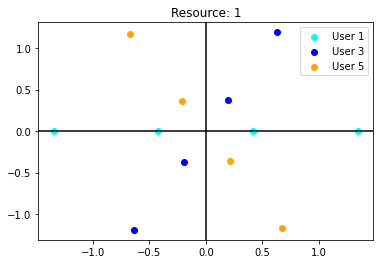

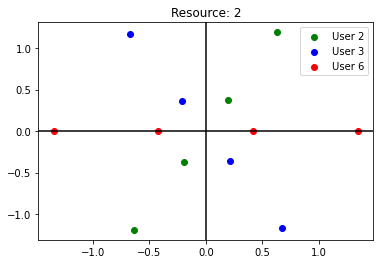

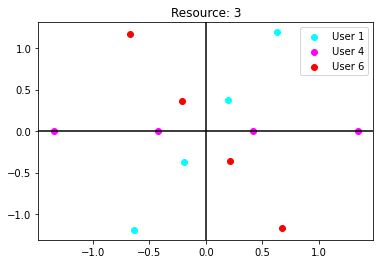

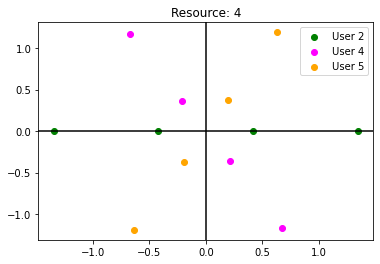

In [14]:
#---See the learned Codebook
batch_size_plot = M
symbols = np.arange(M)+1
symbols = np.stack(J*[symbols], axis=0).transpose()

#---Get codebook
# codebook = get_codebook_from_condensed_codebook()

h_all = []
real_idx = 2 * torch.arange(K).long()

for i in range(J):
  h = np.zeros([J, 2*K])
#   h[i, :] = np.ones([1, 2*K])
  h[i, real_idx] = 1.0
  h = np.stack(batch_size_plot*[h], axis = 0)
  h = torch.Tensor(h).to(device)
  h_all.append(h)


#---Forward Pass
codewords_faded_all = []
for i in range(J):
    codewords_faded, codewords_faded_without_h = encode(symbols, codebook, h = h_all[i])
    codewords_faded_all.append(codewords_faded)



import matplotlib.pyplot as plt
#---code for color assignment for arbitrary num of users
# user_colors = {}
# users = np.arange(J)
# unique_users = list(set(users)) 
# step_size = (256**3) // len(unique_users)
# for i, user in enumerate(unique_users):
#     temp = step_size*i
#     color = np.zeros([3], dtype=np.float32) # RGB
#     for pigment in range(3):
#       r = temp % 256
#       color[pigment] = r/256
#       temp = temp//256
#     user_colors[user] = color.tolist()
# colors = [user_colors[user] for user in users]

colors = ['cyan', 'green', 'blue', 'magenta', 'orange', 'red']

for k in range(K):
  fig, ax = plt.subplots()
  for user in range(J):
    data = codewords_faded_all[user].cpu().detach().numpy()
    if np.abs(data[:, 2*k]).sum()!=0:
    #   pdb()
      ax.scatter(data[:, 2*k], data[:, 2*k+1], c=colors[user], label='User '+str(user+1))
#   pdb()
  ax.legend()
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_title('Resource: '+str(k+1))
  ax.imshow